# Create network from GPM transport data


In [1]:
import shapely.wkb
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import osmnx as ox
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

plt.rcParams['figure.figsize'] = (10, 10)

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_6639/1290785674.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shape

# Railways 

- ~~get lines and stations in IDF~~
- ~~only keep in-scope modes (RER and Metro)~~
- ~~remove stations/bits of lines outside of GPM~~
- ~~clean up dataframes~~    

## Get Data

In [2]:
# Railway lines in IDF
# source: https://data.iledefrance-mobilites.fr/explore/dataset/traces-du-reseau-ferre-idf/map/?location=12,48.7271,2.28086&basemap=jawg.streets

lines = gpd.read_file("data/raw/traces-du-reseau-ferre-idf/traces-du-reseau-ferre-idf.shp").to_crs(2154)

# Only keep RER
lines = lines.loc[lines['mode'] == 'RER']

lines['mode'].unique()

array(['RER'], dtype=object)

In [3]:
# Railway stations in IDF
# source: https://data.iledefrance-mobilites.fr/explore/dataset/emplacement-des-gares-idf/information/

stations = gpd.read_file("data/raw/emplacement-des-gares-idf/emplacement-des-gares-idf.shp").to_crs(2154)

# Only keep RER
stations = stations.loc[stations['mode'] == 'RER']

stations['res_com'].unique()

array(['RER A', 'RER C', 'RER E', 'RER D', 'RER B'], dtype=object)

(622966.2013086217, 686932.8488897617, 6794027.13902586, 6912666.344766285)

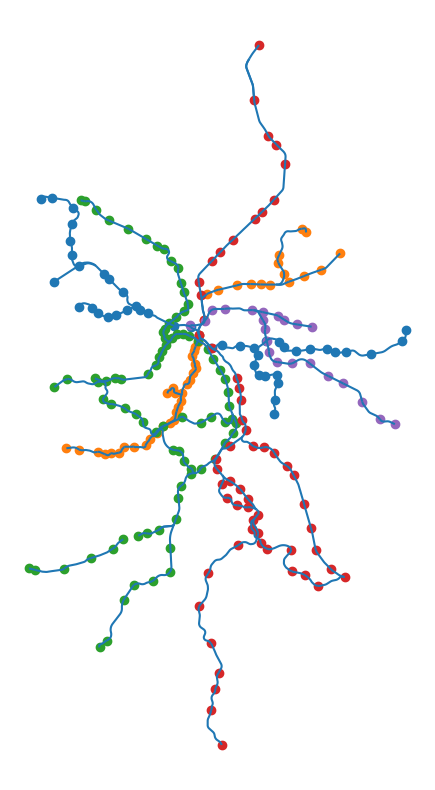

In [4]:
ax = plt.axes()
lines.groupby('reseau').plot(ax=ax)
stations.groupby('ligne').plot(ax=ax)
ax.axis('off')

## Filter for GPM

In [5]:
#--- Create same boundary as for the carbike network

# Get GPM boundary
GPM = gpd.read_file('data/raw/GPM.geojson')
GPM = GPM.to_crs(2154)

# Add a buffer
buffer_dist = 500

# Get convex hull of the area
GPM_hull = gpd.GeoDataFrame({"geometry": GPM.convex_hull})
GPM_hull = GPM_hull.to_crs(GPM.crs)
# Buffer the convex hull
GPM_hull_buff = gpd.GeoDataFrame({"geometry": GPM_hull.buffer(buffer_dist)})
GPM_hull_buff = GPM_hull_buff.to_crs(GPM.crs)

ligne
RER A    Axes(0.184458,0.11;0.656084x0.77)
RER B    Axes(0.184458,0.11;0.656084x0.77)
RER C    Axes(0.184458,0.11;0.656084x0.77)
RER D    Axes(0.184458,0.11;0.656084x0.77)
RER E    Axes(0.184458,0.11;0.656084x0.77)
dtype: object

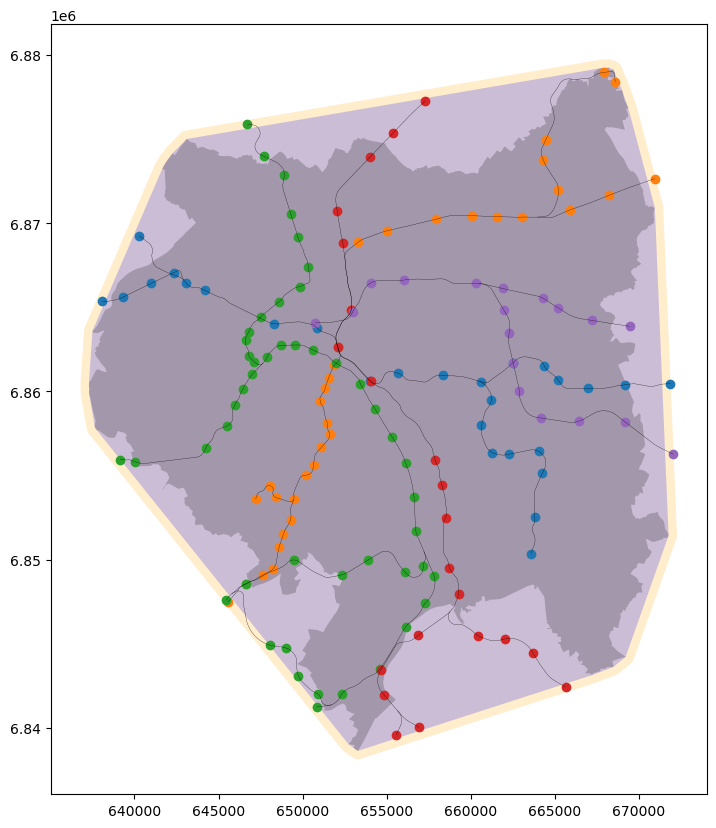

In [6]:
#--- Subset for lines and stations within the boundary
lines_GPM  = gpd.sjoin(lines, GPM_hull_buff, predicate = 'within')
stations_GPM = gpd.sjoin(stations, GPM_hull_buff, predicate = 'within')

# Plot for test
ax = plt.axes()
GPM_hull_buff.plot(ax = ax, color = "orange", alpha=0.2)
GPM_hull.plot(ax = ax, color = "blue", alpha = 0.2)
GPM.plot(ax = ax, color = "black", alpha = 0.2)
lines_GPM.groupby('reseau').plot(ax=ax, linewidth = 0.2, color = 'black')
stations_GPM.groupby('ligne').plot(ax=ax)

## Clean Data

In [7]:
#--- Cleaning up the lines dataframe

# Keep the transport mode, transport line, length of edge and geometry columns
col_tokeep = ['reseau', 'shape_leng', 'geometry']

lines_GPM_clean = lines_GPM[col_tokeep]
lines_GPM_clean['reseau'].unique()


array(['RER C', 'RER E', 'RER B', 'RER A', 'RER D'], dtype=object)

In [8]:
#--- Cleaning up the stations dataframe
col_tokeep = [ 'ligne', 'x', 'y', 'geometry']
stations_GPM_clean = stations_GPM[col_tokeep].reset_index(drop = True).reset_index(drop = False)
stations_GPM_clean = stations_GPM_clean.rename(columns = {'index' : 'id'})
stations_GPM_clean['ligne'].unique()


array(['RER C', 'RER A', 'RER E', 'RER D', 'RER B'], dtype=object)

In [9]:
# Save for QGIS
lines_GPM_clean.to_file("data/processed/lines_GPM_TOMERGE.shp")
stations_GPM_clean.to_file("data/processed/stations_GPM.shp")


In [10]:
# Get QGIS merged lines
lines_GPM_clean = gpd.read_file("data/processed/lines_GPM.shp")

In [11]:
#--- Where possible, match stations with lines based on matching geometries
lines_GPM = lines_GPM_clean.to_crs(4326)
stations_GPM = stations_GPM_clean.to_crs(4326)

# Extract start and end coordinates of lines from the geometry column
lines_GPM['start'] = lines_GPM['geometry'].apply(lambda x: x.coords[0])
lines_GPM['end'] = lines_GPM['geometry'].apply(lambda x: x.coords[-1])


# Round the coordinates to 3 decimals
lines_GPM['start'] = lines_GPM['start'].apply(lambda x: (round(x[0], 3), round(x[1], 3)))
lines_GPM['end'] = lines_GPM['end'].apply(lambda x: (round(x[0], 3), round(x[1], 3)))


# In the stations dataframe, save the geometry as a tuple
stations_GPM['coord'] = stations_GPM['geometry'].apply(lambda x: (round(x.x, 3), round(x.y, 3)))

# Create a dictionary of the stations coordinate and id
stations_GPM = stations_GPM.reset_index(drop = True).rename(columns = {'index':'id'})
stations_dict = dict(zip(stations_GPM['coord'], stations_GPM['id']))

# Create a column in lines_GPM with the id of the start and end stations
lines_GPM['u'] = lines_GPM['start'].apply(lambda x: stations_dict[x] if x in stations_dict else np.nan)
lines_GPM['v'] = lines_GPM['end'].apply(lambda x: stations_dict[x] if x in stations_dict else np.nan)

# Remove useless columns
lines_GPM = lines_GPM.drop(columns = ['start', 'end'])
stations_GPM = stations_GPM.drop(columns = ['coord'])
lines_GPM.isnull().sum()

id            0
reseau        0
shape_leng    0
geometry      0
u             0
v             0
dtype: int64

<Axes: >

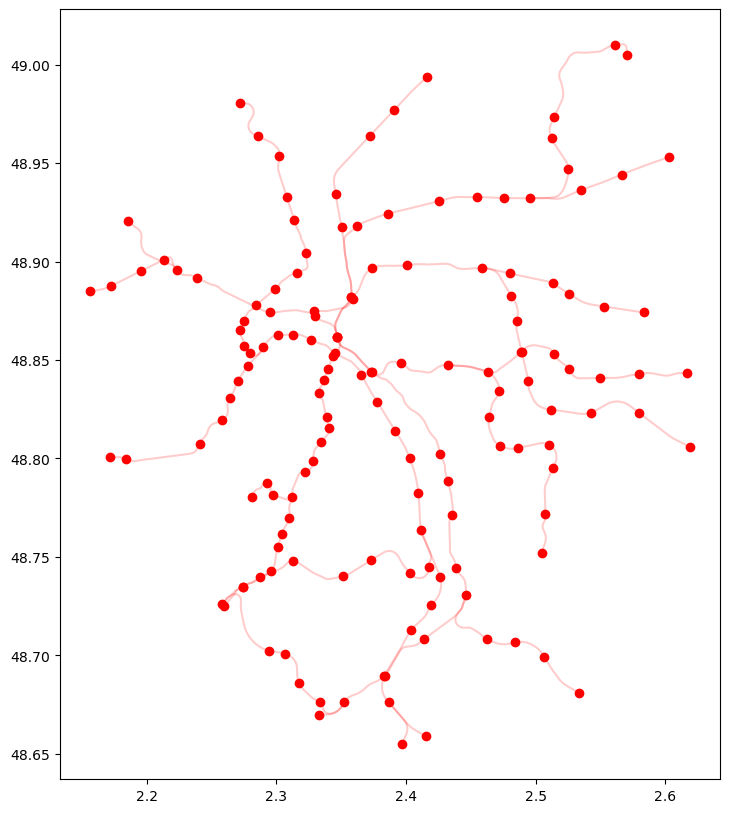

In [12]:
ax = plt.axes() 
lines_GPM.plot(ax=ax, color = 'red', alpha = 0.2)
stations_GPM.plot(ax=ax, color = 'red')

## Create the NetworkX datasets

In [18]:
# Helper function (Anastassia)
def make_attr_dict(*args, **kwargs): 
    
    argCount = len(kwargs)
    
    if argCount > 0:
        attributes = {}
        for kwarg in kwargs:
            attributes[kwarg] = kwargs.get(kwarg, None)
        return attributes
    else:
        return None # (if no attributes are given)

In [19]:
#--- Add relevant columns

# For lines
lines_GPM['edgetype'] = 'RER'
lines_GPM = lines_GPM.rename(columns = {'u': 'x' , 'v' : 'y', 'shape_leng': 'length'})

# For stations
stations_GPM['nodetype'] = 'bike'
stations_GPM['centroid'] = False
stations_GPM['RER'] = True

In [25]:
# Create NetworkX Graph with stations and lines
G = nx.from_pandas_edgelist(lines_GPM, source='x', target='y', edge_attr=True, create_using=nx.DiGraph)
stations_GPM["attr_dict"] = stations_GPM.apply(lambda x: make_attr_dict(lat = x.x,
                                                                  lon = x.y,
                                                                  nodetype = x.nodetype,
                                                                  centroid = x.centroid,
                                                                  RER = x.RER,
                                                                  pos = (x.x,x.y)),
                                                                  axis = 1) 
G.add_nodes_from(stations_GPM.loc[:,["id", 'attr_dict']].itertuples(index=False))
pos = nx.get_node_attributes(G,('pos'))


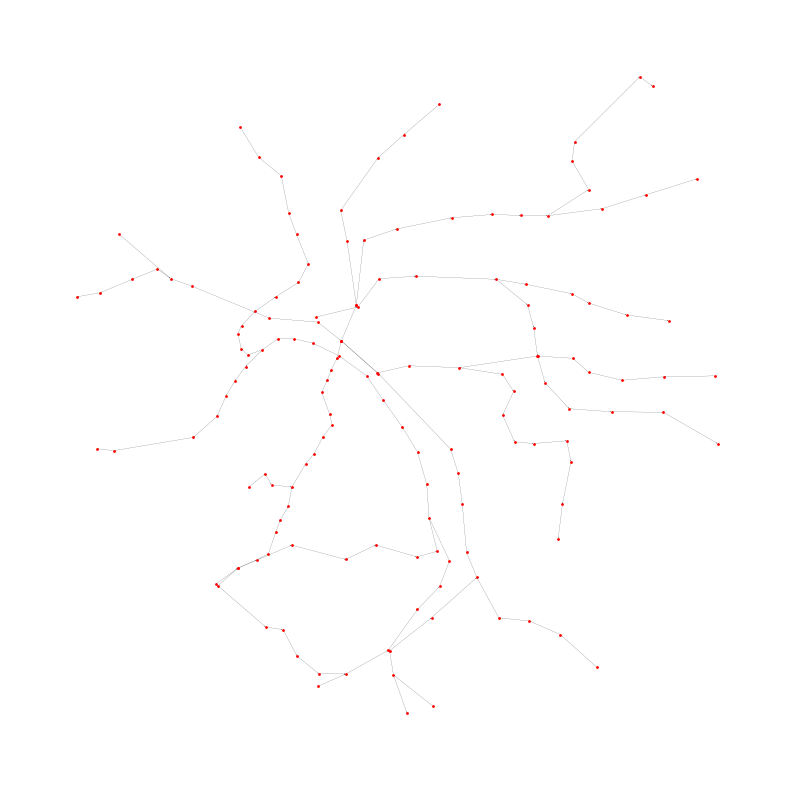

In [26]:
ax = plt.axes()
nx.draw(G, ax=ax, pos=pos, node_size = 1,node_color='red', edge_color='black', width=0.1, arrowsize=1)

In [33]:
#--- Save for future use
stations_final = pd.DataFrame(stations_GPM.to_crs(2154))
stations_final.to_csv("./data/processed/RER_stations.csv")

lines_final = pd.DataFrame(lines_GPM.to_crs(2154))
lines_final.to_csv("./data/processed/RER_lines.csv")